## GW analysis with DM effects (EMRI)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy.integrate import solve_ivp, quad

In [2]:
# Define some useful constants and relations
G = const.G
c = const.c

#conversion factors
m2pc = u.pc / const.pc
solar2kg = const.M_sun / u.M_sun
s2hr = u.hour / u.s / (60*60) 
yr2s = 3.154e+7 * u.s

## Useful functions from last notebook

In [91]:
#calculate rsp given Mbh in solar masses, rho_sp in solar masses/pc^3 and spike coefficient gamma
#returns spike radius in pc
def rsp(M, rho, gamma):
    return 1.08e-1 * (  (3-gamma)**(1/3) * (0.2)**(-gamma/3) ) * (M/const.M_sun)**(1/3) * (rho /(u.M_sun / u.pc**3) ) **(-1/3) * u.pc


#calculate halo density given r in pc, rhosp in solar masses/pc^3 and m1 in solar masses
#returns density in solar mass / pc^3
def rho(r, rhosp, gamma, m1):
#     if (r < 4 * G * m1 / c**2 * m2pc):
#         return 0 * rhosp
#     else:
    return rhosp * ( r / rsp(m1,rhosp,gamma)) **(-gamma)

#Function to calculate the radial decay due to GW and DM energy loss
#time is given in seconds (although no astropy units are explicilty used as the 
#numerical solver sin't compatible with those objects)

def dadt(t, a0, m1, m2, rhosp, gamma ):
    
    #computing the total and reduced mass
    m = m1 + m2
    mu = m1*m2 / (m)
    
    a = a0*u.m
    l_log = np.log(m1 / m2) / 2
    
    phi = np.sqrt( G * m / a**3  )
    v  = np.sqrt( G * m  / a )      #from virial theorem K = -1/2 U -> 1/2 m v^2 = G m / 2a 
    
    return -2*a**2 / (G * m * mu) * (  32/5 * G**4 * mu**2 * m**3 / (c**5 * a**5) 
                                     + 4*np.pi*G**2 * mu**2 * rho(a * m2pc , rhosp, gamma, m1) * l_log / v * solar2kg *m2pc**3 ) *u.s / u.m 

def dadt_nodm(t, a0, m1, m2 ):
    
    #computing the total and reduced mass
    m = m1 + m2
    mu = m1*m2 / (m)
    
    a = a0*u.m
    l_log = np.log(m1 / m2) / 2
    
    phi = np.sqrt( G * m / a**3  )
    v  = np.sqrt( G * m  / a )      #from virial theorem K = -1/2 U -> 1/2 m v^2 = G m / 2a 
    
    return -2*a**2 / (G * m * mu) * (  32/5 * G**4 * mu**2 * m**3 / (c**5 * a**5) ) *u.s / u.m
#This returns the overal orbital decay dr/dt in units of m/s (that's why they're removed at the end as 
#to be compatitble with the numerical solver)

#function to terminate the evolution when the binary has a separation of about 1 risco
def terminator_nodm(t, a, m1, m2):
    return a - 6*const.G * m1 / const.c**2 /u.m

#function to terminate the evolution when the binary has a separation of about 1 risco (only for the DM case)
def terminator_dm(t, a, m1, m2, rhosp, gamma ):
    return a - 6*const.G * m1 / const.c**2 /u.m
terminator.terminal = True

#Functions to that compute f_gw / dot(f)_gw as a function of the given gravitaitonal wave frequency f_gw
#The input (f0) is in Hz without astropy units to avoid conflicts with the numerical solver

#for a system without dark matter
def fgw_nodm(f0, m1, m2):
    
    #computing the total mass
    m = m1 + m2
    
    #computing the orbital frequency
    forb = f0 / 2 / u.s
    #computing semimajor axis from the orbital frequency
    a = ( const.G * m / (forb)**2) **(1/3)  
    #computing the decay in semimajor axis
    da = dadt_nodm(0, a / u.m, m1, m2 )
    
    #computing fdot
    fdot = -3 * (G * m) **(-1/3) * (forb)**(5/3) * (da * u.m / u.s) 
    #removing the units for fdot
    fdot = fdot * (u.s)**2
    #computing f_gw / dot(f)_gw
    f_fdot = f0 / fdot
    
    return f_fdot

#for a system with dark matter
def fgw_dm(f0, m1, m2, rhosp, gamma ):
    
    #computing the total mass
    m = m1 + m2
    
    #computing the orbital frequency
    forb = f0 / 2 / u.s
    #computing semimajor axis from the orbital frequency
    a = ( const.G * m / (forb)**2) **(1/3)  
    #computing the decay in semimajor axis
    da = dadt(0, a / u.m, m1, m2, rhosp, gamma )

    
    #computing fdot
    fdot = -3 * (G * m) **(-1/3) * (forb)**(5/3) * (da * u.m / u.s) 
    #removing the units for fdot
    fdot = fdot * (u.s)**2
    #computing f_gw / dot(f)_gw
    f_fdot = f0 / fdot
    
    return f_fdot

#final frequency
def fend(a, m1, m2):
    return np.sqrt( const.G * (m1+ m2) / a**3)

#function to compute at which approximate radius the evolution becomes visible for a detector sensitivity of f_minimum
#and total mass of the system "m"

def a_start(f_minimum, m):
    forb = 0.5 * f_minimum
    return (G * m / forb**2) ** (1/3)

## Function for evolving the different cases given the grids for the total masses and mass ratios 

In [92]:
def evolver_emri(n,mtot,mq, Z, gamma, rhosp):
    for i in range(0,n):
        for j in range(0,n):
            
            #setting the masses
            m2 =  mtot[0][i] * mq[j][0] / (1 + mq[j][0] ) * const.M_sun
            m1 =  mtot[0][i] * const.M_sun - m2
            
            risco = 6 * G * m1 / c**2
            
            fmin = 1e-3 #minimm frequency at which the signal can be detectable to the detector
            a0 = a_start(fmin / u.s, m1 + m2)

            #coalescence time
            tcoal = 5/256 * const.c**5 * a0**4 / ( const.G**3 * (m1+m2) * (m1 * m2)  )
            tend = yr2s * 5 /u.s #evolving for 5 years and removing the units (seconds)
            
            
            #Solving the system for the final frequency

            sol_dm = solve_ivp(dadt, args = ( m1, m2, rhosp, gamma ), t_span = [0, tend], y0 = [a0 / u.m], events=terminator_dm,
                               dense_output=True, method = 'RK45' , atol=1e-6, rtol=1e-5)
            sol_nodm = solve_ivp(dadt_nodm, args = (m1, m2 ), t_span = [0, tend], y0 = [a0 / u.m], events=terminator_nodm,
                               dense_output=True, method = 'RK45' , atol=1e-6, rtol=1e-5)
            
            a_dm =  sol_dm.sol(sol_dm.t[-1])[0]
            a_nodm =  sol_nodm.sol(sol_nodm.t[-1])[0]
            fmax_dm = fend(a_dm * u.m, m1 ,m2) * u.s  #final frequency in hertz (removing units as numerical integration 
                                                   #requires unitless quantities)
            fmax_nodm = fend(a_nodm * u.m, m1 ,m2) * u.s  #final frequency in hertz (removing units as numerical integration 
                                                   #requires unitless quantities)

            #manually putting the lisa f_max in Hz, as in 0.1 hz
            if fmax_dm > 1e-1 :
                fmax_dm = 1e-1
            if fmax_nodm > 1e-1:
                fmax_nodm = 1e-1

                
            #Integrating the number of cycles
            N_nodm = quad(fgw_nodm, fmin , fmax_nodm, args = (m1, m2) )[0]
            
            N_dm = quad(fgw_dm, fmin , fmax_dm, args = ( m1, m2, rhosp, gamma ) )[0]
            

            Z[j][i] = np.abs(N_nodm - N_dm) * 2 * np.pi

            print('\r' + str(j) + ", Completion : " + str(i+1) + "/" + str(n), end='', flush=True)
            
    return Z

## Giving the system the dark matter conditions and total masses / mass ratio arrays

In [93]:
#Array configuration for 1-100 Msolar 

#mass ratio that spans 1e-4 - 1e-5
mq_array = [0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]
mq = np.meshgrid(mq_array, mq_array)[1] * 1e-4

#total mass that spans 1e4 - 1e5 solar masses
mtot_array = [0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]
mtot = np.meshgrid(mtot_array, mtot_array)[0] * 1e5

#array to store number of cycles
Z100 = mtot * mq * 0.0

#length of array
n = 11

#Halo properties:
gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

Z100 = evolver_emri(n,mtot,mq, Z100, gamma, rhosp)

10, Completion : 11/11

## Plotting the results

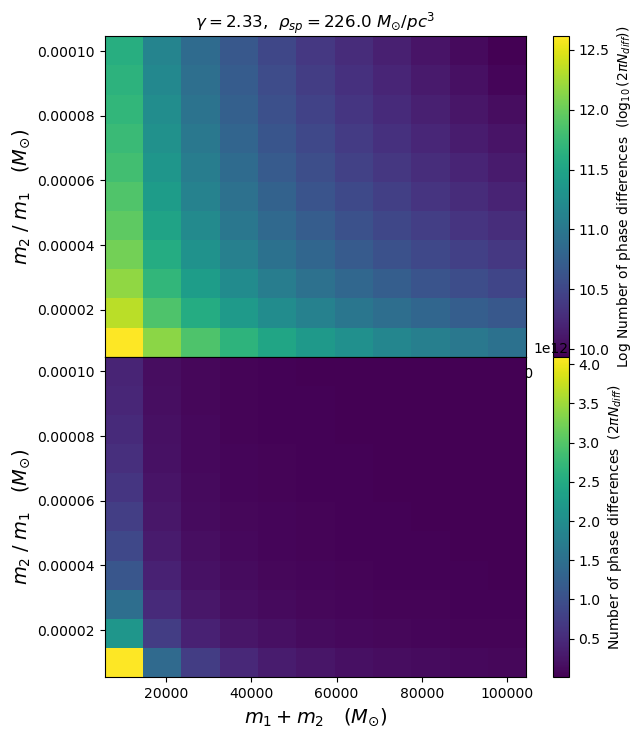

In [99]:
plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)


plt.pcolormesh(mtot,mq, np.log10(Z100) )
plt.ylabel('$m_2 \; / \; m_1 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
# title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
# title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +') \n'
# title_ambient = 'Ambient dark matter: ' + '{:.1E}'.format(rho(R * m2pc , rhosp, gamma, M1) * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"

plt.title(title_gamma +  title_rho )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log_{10}{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(mtot,mq, Z100)
plt.xlabel('$m_1 + m_2 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \; / \; m_1 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

## Testing functions (this is just scratch that I used, cleaned up version is summarized above)

## Setting initial conditions for the system

In [98]:
#define the initial parameters of the system (masses and initial semimajor axis)
m1 = 1e3 * const.M_sun
m2 = 1 * const.M_sun


risco = 6 * G * m1 / c**2

m = m1 + m2
mu = m1*m2 / (m)

#DM side
gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3


#Print some of the binary info
#----------------------------------------------------------------------------------------------
print("The masse of m_1 (solar mass) is: ", m1 / const.M_sun)
print("Which has a Schwarzschild radius of (for m_1) " + str( 2 * G * m1 / c**2 / u.m / 1e3 ) + " (km)")
print("The masse of m_1 (solar mass) is: ", m2 / const.M_sun)
print("Which has a Schwarzschild radius of (for m_2) " + str( 2 * G * m2 / c**2 / u.m / 1e3 ) + " (km)")
print("Mass ratio: ", m1/m2)
print("They will start evolving from :" + str( a0/risco) + " (risco) or " + str(a0 / 1e3 /  u.m) + " (km)" )
print("They will stop evolving at 1 risco which is " + str(risco / 1e3 /  u.m) + " (km)" )


fmin = 1e-3 #minimum frequency at which the signal can be detectable to the detector
a0 = a_start(fmin / u.s, m)
print('-------------------------------------------')
print('Total evolution time')
print('For a binary with masses (solar masses) M1: ' + str(m1 / const.M_sun) + str(", and M2: ") + str(m2 / const.M_sun) + ", and separation of " + '{:.3f}'.format(a0 / 1000 /u.m) + str(' km (') +   '{:.3f}'.format(a0 / risco) + str(' risco)')       )
print('will have a coalescing time of')
tcoal = 5/256 * const.c**5 * a0**4 / ( const.G**3 * m**2 * mu )
tcoal * s2hr

The masse of m_1 (solar mass) is:  1000.0
Which has a Schwarzschild radius of (for m_1) 2953.2500761002498 (km)
The masse of m_1 (solar mass) is:  1.0
Which has a Schwarzschild radius of (for m_2) 2.95325007610025 (km)
Mass ratio:  1000.0
They will start evolving from :914.2123610098635 (risco) or 8099693.174172505 (km)
They will stop evolving at 1 risco which is 8859.750228300749 (km)
-------------------------------------------
Total evolution time
For a binary with masses (solar masses) M1: 1000.0, and M2: 1.0, and separation of 8099693.174 km (914.212 risco)
will have a coalescing time of


<Quantity 2.41677569e+10 h>

In [99]:
sol_nodm = solve_ivp(dadt_nodm, [0, tend], [a0 / u.m], dense_output=True, events=terminator, method = 'RK45' , atol=1e-6, rtol=1e-5)
sol = solve_ivp(dadt,[0, tend], [a0 / u.m], dense_output=True, events=terminator, method = 'RK45' , atol=1e-6, rtol=1e-5)
sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  1.000e-04 ...  1.161e+10  1.161e+10]
        y: [[ 8.100e+09  8.100e+09 ...  9.870e+06  8.860e+06]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000022CBC164B20>
 t_events: [array([ 1.161e+10])]
 y_events: [array([[ 8.860e+06]])]
     nfev: 566
     njev: 0
      nlu: 0

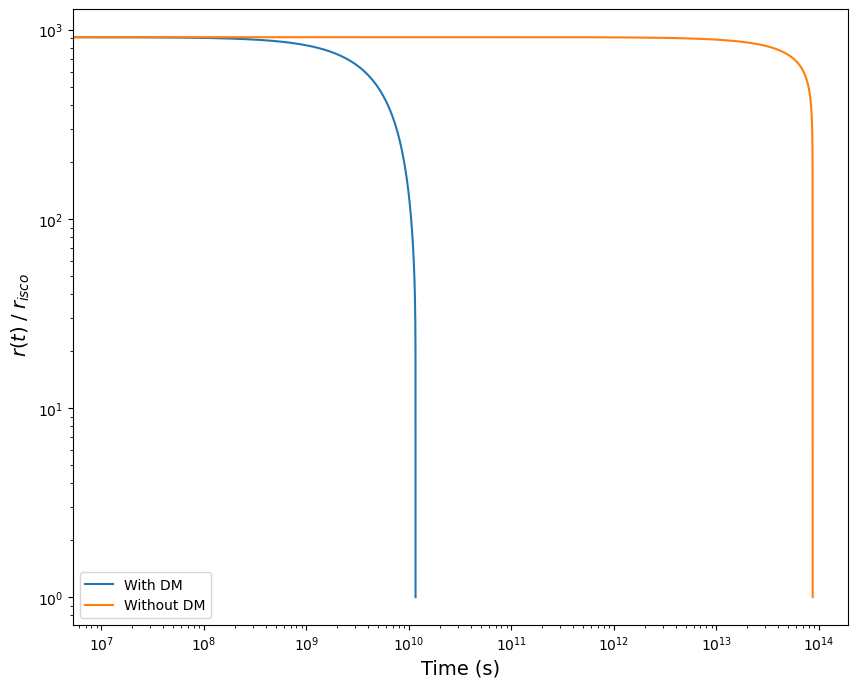

In [100]:
plt.figure(figsize=(10,8))

t0 = np.linspace(0, sol.t[-1],1000)
t1 = np.linspace(0, sol_nodm.t[-1],1000)

plt.plot(t0 , sol.sol(t0)[0] / risco, label="With DM")
plt.plot(t1, sol_nodm.sol(t1)[0] / risco, label = "Without DM")
plt.legend()
plt.ylabel(" $r(t) \; / \; r_{isco} $", fontsize=14)
plt.xlabel("Time (s)", fontsize=14)
plt.yscale('log')
plt.xscale('log')

## Final frequency

In [101]:
a_dm =  sol.sol(t0)[0][-1]
fmax = fend(a_dm * u.m) * u.s
fmax


<Quantity 13.82103727>

In [102]:
#manually putting the lisa f_max
fmax = 1e0 

In [103]:
N_dm = quad(fgw, fmin , fmax )[0]
N_nodm = quad(fgw_nodm, fmin , fmax )[0]

In [105]:
N_diff = N_nodm  - N_dm 
N_diff

139070958733.6507

Fitting for an observational time of 2-4yrs

In [106]:
tend = yr2s * 2 /u.s #evolving for 4 years and removing the units (seconds)

sol_nodm = solve_ivp(dadt_nodm, [0, tend], [a0 / u.m], dense_output=True, events=terminator, method = 'RK45' , atol=1e-6, rtol=1e-5)
sol = solve_ivp(dadt,[0, tend], [a0 / u.m], dense_output=True, events=terminator, method = 'RK45' , atol=1e-6, rtol=1e-5)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  1.111e+07  6.308e+07]
        y: [[ 8.100e+09  8.100e+09 ...  8.091e+09  8.051e+09]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000022CBC1C3910>
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 80
     njev: 0
      nlu: 0

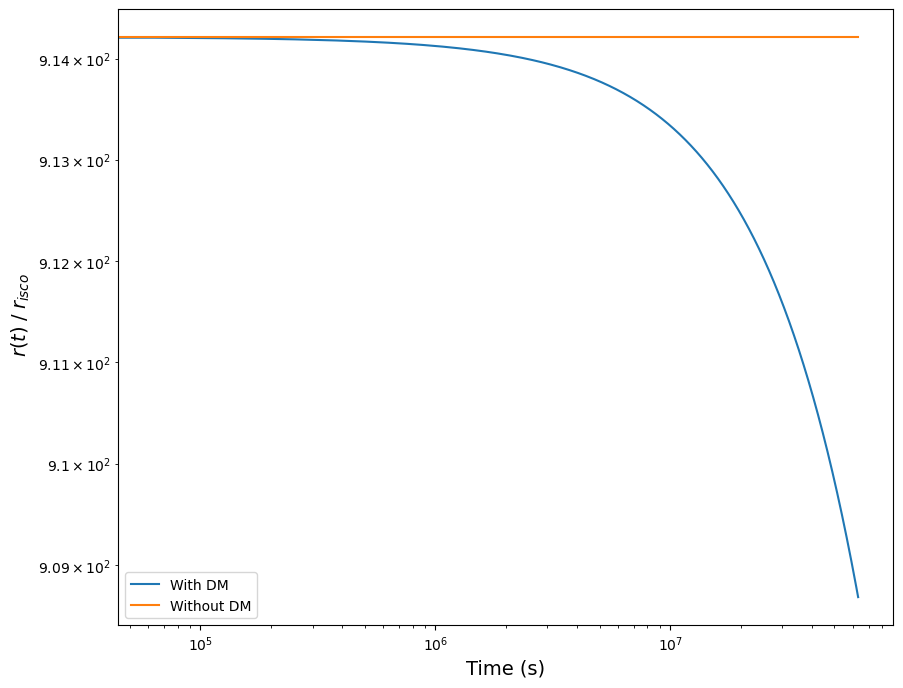

In [107]:
plt.figure(figsize=(10,8))

t0 = np.linspace(0, sol.t[-1],1000)
t1 = np.linspace(0, sol_nodm.t[-1],1000)

plt.plot(t0 , sol.sol(t0)[0] / risco, label="With DM")
plt.plot(t1, sol_nodm.sol(t1)[0] / risco, label = "Without DM")
plt.legend()
plt.ylabel(" $r(t) \; / \; r_{isco} $", fontsize=14)
plt.xlabel("Time (s)", fontsize=14)
plt.yscale('log')
plt.xscale('log')

In [108]:
a_dm =  sol.sol(t0)[0][-1]
a_nodm =  sol_nodm.sol(t1)[0][-1]
fmax_dm = fend(a_dm * u.m) * u.s
fmax_nodm = fend(a_nodm * u.m) * u.s
fmax_dm

<Quantity 0.00050457>

In [114]:
fmax_dm

<Quantity 0.00050457>

In [157]:
fmax_nodm = 0.001000000001

In [158]:
fmin

0.001

In [159]:
N_dm = quad(fgw, fmin , fmax_nodm )[0]
N_nodm = quad(fgw_nodm, fmin , fmax_nodm)[0]

In [160]:
N_diff = N_nodm  - N_dm 
N_diff

232.00351043692524

In [117]:
N_diff = N_dm - N_nodm 
N_diff

302741761014.53467

In [55]:
#creating an aray of frequencies and storage for DM/no DM effects
n = 100 #number of elements

gw_freq = np.linspace(fmin, fmax,n)
N_freq_dm = np.linspace(fmin, fmax,n)
N_freq_nodm = np.linspace(fmin, fmax,n)

for i in range(n):
    N_freq_dm[i] = quad(fgw, fmin , gw_freq[i] )[0]
    N_freq_nodm[i] = quad(fgw_nodm, fmin , gw_freq[i] )[0]